# Forecasting price

### Description
In the dataset 'sample.csv' there are 7 features and 1 target variable ('price'). In this project I will try to make a machine learning model that will forecast the price.

### Data Handling

In [1]:
# Loading and looking at the data
import pandas as pd
data = pd.read_csv('sample.csv')

In [2]:
data.head()

,loc1,loc2,para1,dow,para2,para3,para4,price
0,0,01,1,Mon,662,3000.0,3.8,73.49
1,9,99,1,Thu,340,2760.0,9.2,300.00
2,0,04,0,Mon,16,2700.0,3.0,130.00
3,4,40,1,Mon,17,12320.0,6.4,365.00
4,5,50,1,Thu,610,2117.0,10.8,357.50


There is at least one parameter that will have to be changed later - 'dow'.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   loc1    10000 non-null  object 
 1   loc2    10000 non-null  object 
 2   para1   10000 non-null  int64  
 3   dow     10000 non-null  object 
 4   para2   10000 non-null  int64  
 5   para3   10000 non-null  float64
 6   para4   10000 non-null  float64
 7   price   10000 non-null  float64
dtypes: float64(3), int64(2), object(3)
memory usage: 625.1+ KB


From first columns it seems that the first two features are numeric, but they are in the string format in the dataset and this will have to be changed. Apart from that there are no null entries, which is good.

In [4]:
# Changing the datatypes of the first two features
try:
    data['loc1'] = data['loc1'].astype(int)
except:
    print('There are non-integer values present')

There are non-integer values present


In [5]:
try:
    data['loc2'] = data['loc2'].astype(int)
except:
    print('There are non-integer values present')

There are non-integer values present


There is an error in the columns - some of the values are not numeric and have letters in them.

In [6]:
# Thus, these features might not have any meaningful relationships and dropping them might be a good idea
data.drop(columns=['loc1','loc2'],inplace=True)

In [7]:
data.describe()

,para1,para2,para3,para4,price
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.380800,447.384000,9547.989920,8.459522,433.733056
std,3.500831,221.005861,8022.814037,4.613526,277.435947
min,0.000000,16.000000,200.000000,1.000000,50.730000
25%,1.000000,301.000000,2898.000000,4.000000,250.000000
50%,1.000000,434.000000,6447.000000,7.200000,370.000000
75%,1.000000,582.000000,15000.000000,13.600000,550.000000
max,337.000000,2554.000000,34782.000000,27.200000,5700.000000


The ranges in most variables are relatively huge - some models will need scaling to be done

In [8]:
# Changing the 'dow' feature into weekdays (0) and weekens (1)
week = {'Mon':0,'Tue':0,'Wed':0,'Thu':0,'Fri':0,'Sat':1,'Sun':1}
for i in week:
    data['dow'].replace(to_replace=i,value=week[i],inplace=True)

In [9]:
data.head()

,para1,dow,para2,para3,para4,price
0,1,0,662,3000.0,3.8,73.49
1,1,0,340,2760.0,9.2,300.00
2,0,0,16,2700.0,3.0,130.00
3,1,0,17,12320.0,6.4,365.00
4,1,0,610,2117.0,10.8,357.50


### Checking Outliers and Feature Correlation

In [10]:
# Getting rid of outliers for para2, para3 and target
iqr_para2 = 582 - 301
iqr_para3 = 15000 - 2898
iqr_target = 550 - 250
condition_para2 = (data['para2'] >= 301 - 1.5*iqr_para2) & (data['para2'] <= 582+1.5*iqr_para2)
condition_para3 = (data['para3'] >= 2898 - 1.5*iqr_para3) & (data['para3'] <= 15000+1.5*iqr_para3)
condition_target = (data['price'] >= 250 - 1.5*iqr_target) & (data['price'] <= 550+1.5*iqr_target)
data = data[condition_para2 & condition_para3 & condition_target]

In [11]:
data.describe()

,para1,dow,para2,para3,para4,price
count,9696.000000,9696.000000,9696.000000,9696.000000,9696.000000,9696.000000
mean,1.315285,0.001341,430.952764,9438.400505,8.359635,404.568833
std,0.969317,0.036594,187.388992,7990.290259,4.603430,198.662198
min,0.000000,0.000000,16.000000,200.000000,1.000000,50.730000
25%,1.000000,0.000000,298.000000,2838.250000,4.000000,250.000000
50%,1.000000,0.000000,425.000000,6299.500000,7.000000,360.000000
75%,1.000000,0.000000,572.000000,15000.000000,13.600000,525.000000
max,24.000000,1.000000,1002.000000,28000.000000,27.200000,1000.000000


In [12]:
# Visualizing the correlation among parameters
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\azima\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


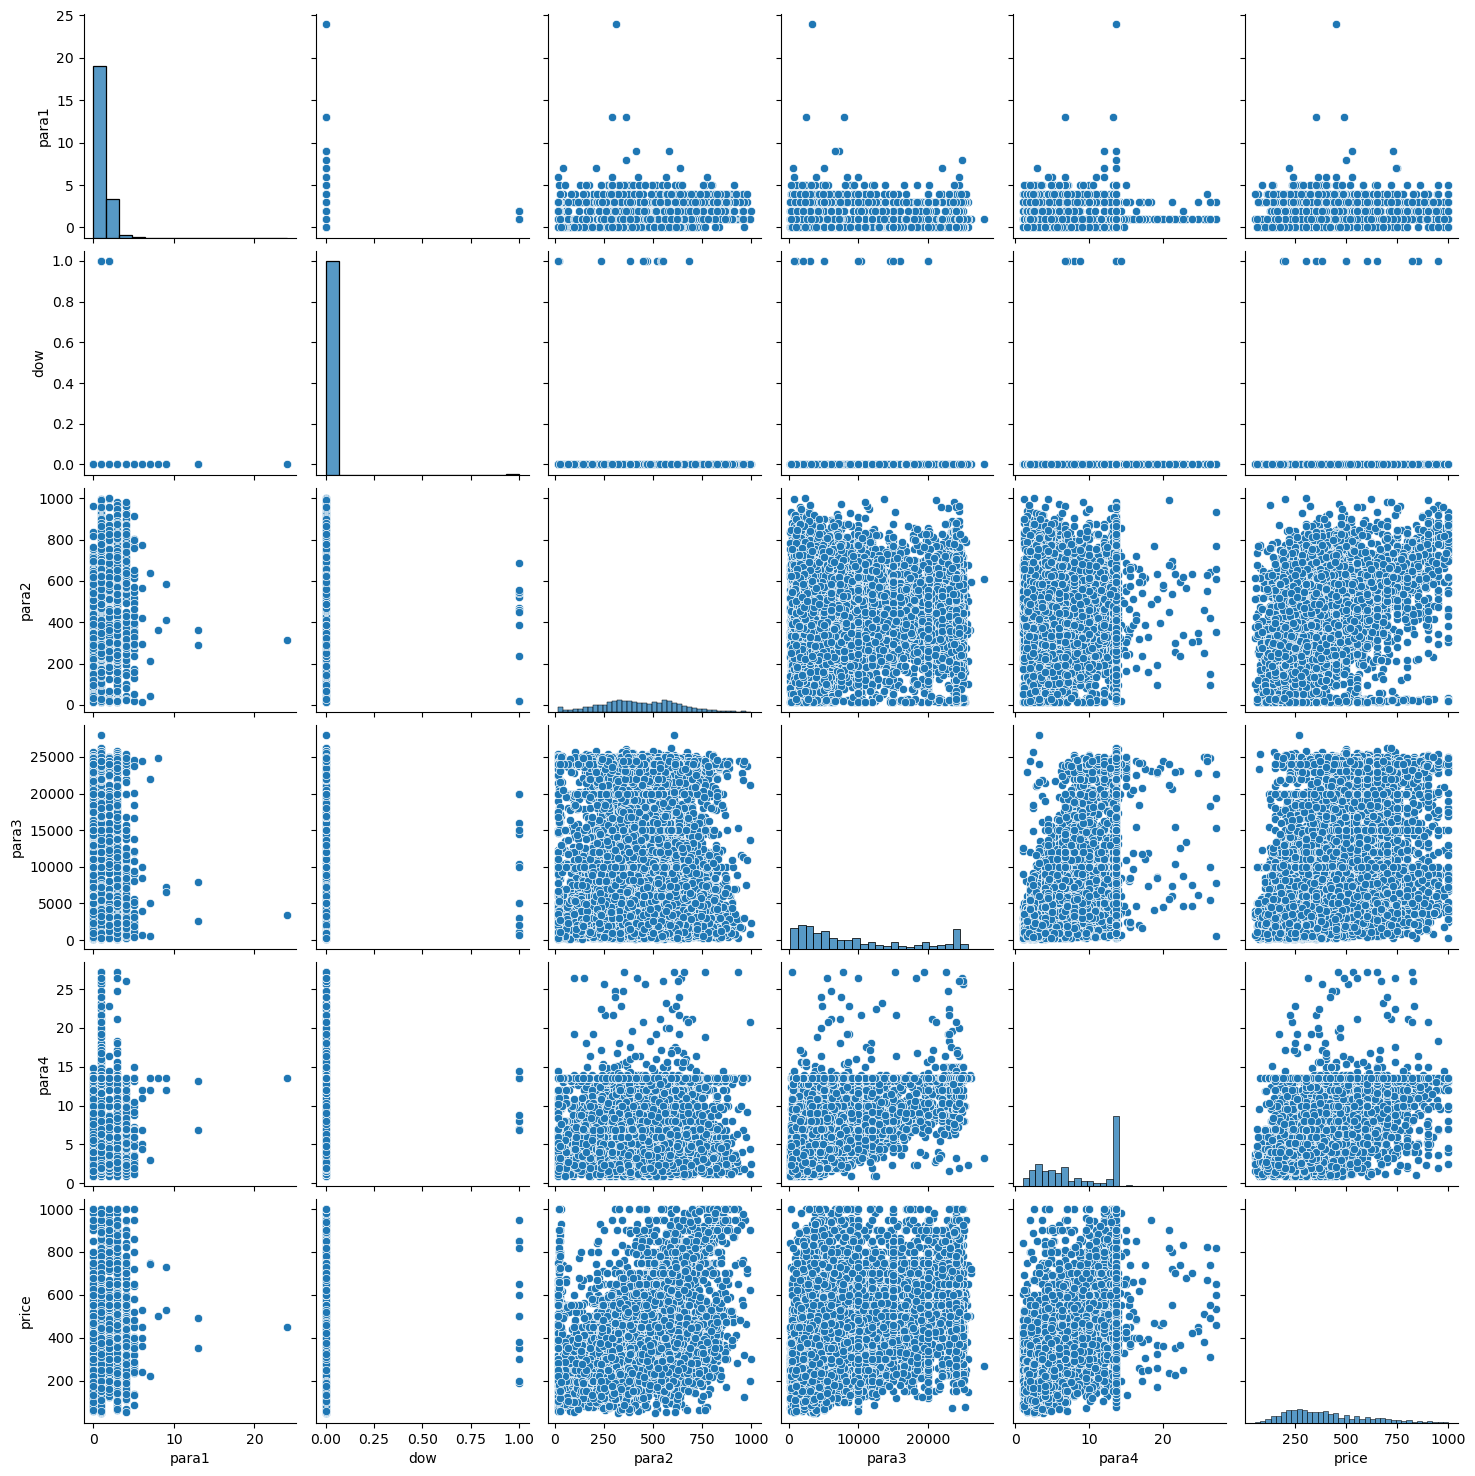

In [13]:
sns.pairplot(data)
plt.show()

The multicollinearity here is hard to see, using another method to look at correlation should be better

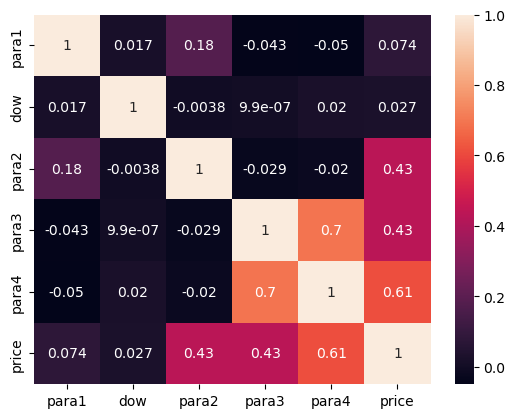

In [14]:
corr = data.corr(numeric_only=True)
sns.heatmap(corr,annot=True)
plt.show()

### Feature Selection

The above correlation matrix shows that para1 almost does not affect the price, but has a correlation with days of week. Para3 and para4 have a strong correlation between each other and the impact on price almost corresponds with this correlation (0.43 ~ 0.61 * 0.71). Thus considering the stronger impact of para4, I will leave para4 and drop para3. Also days of week almost do not affect the price and can be dropped. Last, para1 can be dropped for two reasons: 1) minimal impact on price 2) there is a risk of correlation with para2 (0.074 ~ 0.43 * 0.18), which in turn poses a risk of multicollinearity.

In [15]:
data.drop(columns=['para1','para3','dow'],inplace=True)

In [16]:
data.head()

,para2,para4,price
0,662,3.8,73.49
1,340,9.2,300.00
2,16,3.0,130.00
3,17,6.4,365.00
4,610,10.8,357.50


### Assessing Relevant Models
Using various models for regression in accordance with the target context

In [17]:
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression as LR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.regression.linear_model import OLS

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

### Ordinary-Least Squares

In [18]:
# Looking at the initial statistics of the dataset
model = OLS(data[['price']],data.drop(columns=['price']))

In [19]:
result=model.fit()

In [20]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.917
Model:                            OLS   Adj. R-squared (uncentered):              0.917
Method:                 Least Squares   F-statistic:                          5.330e+04
Date:                Mon, 29 Apr 2024   Prob (F-statistic):                        0.00
Time:                        16:00:32   Log-Likelihood:                         -60963.
No. Observations:                9696   AIC:                                  1.219e+05
Df Residuals:                    9694   BIC:                                  1.219e+05
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
para2          0.4412      0.005     94.257      0.000       0.432       0.450
para4         25.9236      0.231    112.463      0.000      25.472      26.375
==============================================================================
Omnibus:                      987.685   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2300.592
Skew:                           0.617   Prob(JB):                         0.00
Kurtosis:                       5.042   Cond. No.                         82.0
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Preparing Data

In [21]:
# Splitting the data into train-test datasets
x_train,x_test,y_train,y_test = train_test_split(data.drop(columns=['price']),data[['price']],test_size=0.3,random_state=42)

In [22]:
# Using scaling immediately to be able to compare feature coefficients if need be
minmax = MinMaxScaler()
standard = StandardScaler()
x_train_mm = minmax.fit_transform(x_train)
x_train_ss = standard.fit_transform(x_train)
x_test_mm = minmax.transform(x_test)
x_test_ss = standard.transform(x_test)

In [23]:
# Making the dataframes of the obtained results
x_train_mm = pd.DataFrame(x_train_mm,columns=x_train.columns)
x_train_ss = pd.DataFrame(x_train_ss,columns=x_train.columns)
x_test_mm = pd.DataFrame(x_test_mm,columns=x_train.columns)
x_test_ss = pd.DataFrame(x_test_ss,columns=x_train.columns)

I will use the RMSE measure for error comparison since this value should be closer in dimension to our price values and hence more convenient.

### Linear Regression

In [24]:
# LinReg MinMaxScaler
linreg1 = LR()
linreg1.fit(x_train_mm,y_train)
predict1 = linreg1.predict(x_test_mm)
MSE(y_test,predict1) ** (1/2), r2_score(y_test,predict1)

(131.6795396934365, 0.5700564898932159)

In [25]:
# LinReg StandardScaler
linreg2 = LR()
linreg2.fit(x_train_ss,y_train)
predict2 = linreg2.predict(x_test_ss)
MSE(y_test,predict2) ** (1/2), r2_score(y_test,predict2)

(131.6795396934365, 0.5700564898932159)

The results came out to be identical. Overall the root mean squared error is acceptable considering the standard deviation and range of data, but more concept is needed to be sure about this, which for this dataset I do not have. There seems to be room for improving the R2-score. After this I am going to use MinMaxScaler results only for two reasons: 1) there are no negative values in our features and 2) I got rid of all the outliers to which MinMaxScaler is sensitive

In [26]:
# Checking the model for any overfitting
predict1_tr = linreg1.predict(x_train_mm)
MSE(y_train,predict1_tr) ** (1/2), r2_score(y_train,predict1_tr)

(129.18589933318918, 0.5730427250738553)

Overfitting is negligible

### Decision Tree Regressor

In [27]:
# Trying the decision tree for which scaling is not necessary
# max_features only has 2 values for the dimensions of the final dataset
tree = DecisionTreeRegressor(random_state = 42)
params = {
         'max_depth': range(1,7),
          'max_features': [1,2]
         }
tree_search = GridSearchCV(estimator=tree,param_grid=params,scoring='neg_mean_squared_error',cv=3)
tree_search.fit(x_train,y_train)
prediction = tree_search.predict(x_test)
tree_search.best_estimator_

DecisionTreeRegressor(max_depth=5, max_features=2, random_state=42)

In [28]:
# Just checking for overfitting
prediction_tr = tree_search.predict(x_train)

In [29]:
MSE(y_test,prediction) ** (0.5), MSE(y_train,prediction_tr) ** (0.5)

(124.16018213219452, 117.59779771495799)

In [30]:
r2_score(y_test,prediction), r2_score(y_train,prediction_tr)

(0.6177570533850889, 0.6462042843795808)

The error is lower than for linear regression. There is a slight overfitting.

### Random Forest Regressor

In [31]:
import numpy as np

In [32]:
forest = RandomForestRegressor(random_state=42)
params = {'n_estimators': [100,200],
         'max_depth': range(1,7),
          'max_features': [1,2]
         }
forest_search = GridSearchCV(estimator=forest,param_grid=params,scoring='neg_mean_squared_error',cv=3)
# Had to change the shape since it was in the form of a matrix for starters
forest_search.fit(x_train,np.reshape(y_train,(6787,)))
prediciton = forest_search.predict(x_test)
forest_search.best_estimator_

RandomForestRegressor(max_depth=6, max_features=2, n_estimators=200,
                      random_state=42)

In [33]:
prediction_tr = forest_search.predict(x_train)

In [34]:
MSE(y_test,prediction) ** (0.5), MSE(y_train,prediction_tr) ** (0.5)

(124.16018213219452, 111.36604181478275)

In [35]:
r2_score(y_test,prediction), r2_score(y_train,prediction_tr)

(0.6177570533850889, 0.6827075337114792)

The error is comparable with the decision tree. Overfitting is more significant.

### SVM

In [36]:
svm = SVR(kernel = 'poly')
params = {
    'degree' : range(2,7),
    'C' : [0.1,1,10]
}
svm_search = GridSearchCV(estimator=svm,param_grid=params,scoring='neg_mean_squared_error',cv=3)
# Using scaled data because of the dependency of the model on distance
svm_search.fit(x_train_mm,np.reshape(y_train,(6787,)))
svm_search.best_estimator_

SVR(C=0.1, degree=2, kernel='poly')

In [37]:
prediction = svm_search.predict(x_test_mm)
prediction_tr = svm_search.predict(x_train_mm)

In [38]:
MSE(y_test,prediction) ** (0.5), MSE(y_train,prediction_tr) ** (0.5)

(132.77445294714758, 127.64282216493353)

In [39]:
r2_score(y_test,prediction), r2_score(y_train,prediction_tr)

(0.5628768173104466, 0.5831814987200192)

As can be seen the model with larger regularization happened to be better during hyperparameter selection. But the error in this case is significant (even worse than simple linear regression). It could be due to the greater regularizaion force that makes the model prefer a greater distance between planes.

### K Nearest Neighbors

In [40]:
knn = KNeighborsRegressor()
params = {'n_neighbors':range(2,21),
         'weights':['uniform','distance']}
knn_search = GridSearchCV(estimator=knn,param_grid=params,scoring='neg_mean_squared_error',cv=3)
knn_search.fit(x_train_mm,y_train)
knn_search.best_estimator_

KNeighborsRegressor(n_neighbors=20)

In [41]:
# The following attribute was not displayed above, so I am looking at it here
knn_search.best_estimator_.weights

'uniform'

In [42]:
prediction = knn_search.predict(x_test_mm)
prediction_tr = knn_search.predict(x_train_mm)

In [43]:
MSE(y_test,prediction) ** (0.5), MSE(y_train,prediction_tr) ** (0.5)

(123.06838181032771, 113.29021459437892)

In [44]:
r2_score(y_test,prediction), r2_score(y_train,prediction_tr)

(0.6244499892366477, 0.6716485103282097)

The error here is minimal among the used models but there is a slight overfitting. Since the number of neighbors happened to be at the boundary (20), I will check greater numbers.

In [45]:
knn = KNeighborsRegressor()
params = {'n_neighbors':range(20,41)}
knn_search = GridSearchCV(estimator=knn,param_grid=params,scoring='neg_mean_squared_error',cv=3)
knn_search.fit(x_train_mm,y_train)
knn_search.best_estimator_

KNeighborsRegressor(n_neighbors=27)

In [46]:
prediction = knn_search.predict(x_test_mm)
prediction_tr = knn_search.predict(x_train_mm)

In [47]:
MSE(y_test,prediction) ** (0.5), MSE(y_train,prediction_tr) ** (0.5)

(122.4261134598076, 114.58895683976553)

In [48]:
r2_score(y_test,prediction), r2_score(y_train,prediction_tr)

(0.6283595960080048, 0.6640770126898046)

New number of neighbors - 27. The error and overfitting in this case are even less.

### Conclusion

Out of all the used models, the best one are the decision tree and K nearest neighbors if we consider error and overfitting. Overall, the best model is K Nearest Neighbors considering the speed of its use.